In [1]:
student_id = "402200253"
student_name = "Alireza Abbasian"

print("your student id:", student_id)
print("your name:", student_name)

your student id: 402200253
your name: Alireza Abbasian


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import re
from sklearn.model_selection import KFold

In [3]:
seed_val = 1402


np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device = ",device)

device =  cuda


# preprocess

In [4]:
# read BBBP.csv file
df = pd.read_csv('BBBP.csv')
print(df.head())

   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  


In [5]:
# the p_np column is the label
p_np = df['p_np'].values

# the smiles column is the input
smiles = df['smiles'].values

# create smiles_pnp_dict dict
smiles_pnp_dict = {}
for i in range(len(smiles)):
    smiles_pnp_dict[smiles[i]] = p_np[i]

print("number of smiles = ", len(smiles_pnp_dict))

# print first 10 smiles with their labels using smiles_pnp_dict dict
for i, (k, v) in enumerate(smiles_pnp_dict.items()):
    print(k, " : ", v)
    if i == 10:
        break

number of smiles =  2050
[Cl].CC(C)NCC(O)COc1cccc2ccccc12  :  1
C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  :  1
c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO3)=O  :  1
C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  :  1
Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O  :  1
CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(N3C2=O)C(O)=O)CSc4nnnn4C)c5ccc(O)cc5)C(=O)C1=O  :  1
CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@@]3(C)O)C(=O)[C@]2(O)C(=O)\C(=C(/O)NCN5CCCC5)C1=O  :  1
Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14  :  1
COc1ccc(cc1)[C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O  :  1
NC(N)=NC(=O)c1nc(Cl)c(N)nc1N  :  1
OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1  :  0


Elements:
Single-letter Elements:

C - Carbon

N - Nitrogen

O - Oxygen

S - Sulfur

P - Phosphorus

F - Fluorine

Cl - Chlorine

Br - Bromine

I - Iodine

Single-letter Elements (Aromatic):

c - Aromatic carbon

n - Aromatic nitrogen

o - Aromatic oxygen

s - Aromatic sulfur

p - Aromatic phosphorus

Two-letter Elements:

Br - Bromine

Cl - Chlorine

Li - Lithium

Na - Sodium

K - Potassium

Ca - Calcium

Mg - Magnesium

and others...

Rules:

Hydrogens:

Implicit hydrogen atoms are assumed. They are not explicitly written unless needed for clarity.

Bonds:

Single bonds are represented by - (e.g., CC).

Double bonds are represented by = (e.g., C=C).

Triple bonds are represented by # (e.g., C#C).

Aromaticity:

Aromatic rings are often represented using lowercase letters (c, n, o, s, p).
Aromaticity can also be indicated using aromatic symbols like c1ccccc1 for benzene.

Branching:

Branching is indicated by parentheses, for example, (CC)O represents the alcohol group attached to a carbon.

Ring Closure:

Ring closure is indicated by using numbers. For example, C1CCCCC1 represents a cyclohexane ring.

Chirality:

Chiral centers are indicated using @ and @@ symbols. For example, C[C@H](F)O represents a chiral center.

Isotopes:

Isotopes are represented using [mass_number] in square brackets. For example, [13CH4] represents carbon-13 methane.

Charge:

Positive and negative charges are indicated by + and -, respectively.

In [6]:
# we need to convert the smiles to a list of integers(each element  is represented by an integer)

smiles_pattern = re.compile(r'(\[[^\]]+\]|Br?|Cl?|I|C?|c?|N?|n?|O?|o?|F?|S?|s?|\(|\)|\.|=|#|-|\+|\\|/|:|~|@|\?|>|<|\*|%[0-9]{2}|[0-9])')

# Example SMILES string
smiles_str = smiles[0]

# Find matches using the pattern
matches = re.findall(smiles_pattern, smiles_str)
matches = [match for match in matches if match]

# Print the matches
print(matches)

['[Cl]', '.', 'C', 'C', '(', 'C', ')', 'N', 'C', 'C', '(', 'O', ')', 'C', 'O', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']


In [7]:
vocab_count_dict = {}
smiles_lengths_dict = {}
vocab_2_index_dict = {}
index_2_vocab_dict = {}
smiles_2_vocab_dict = {}

for smiles_str in smiles:
    matches = re.findall(smiles_pattern, smiles_str)
    matches = [match for match in matches if match]


    smiles_2_vocab_dict[smiles_str] = matches

    # Update vocabulary counts
    for match in matches:
        vocab_count_dict[match] = vocab_count_dict.get(match, 0) + 1

    # Save the length of each SMILES string
    smiles_lengths_dict[smiles_str] = len(matches)

vocab_count_dict = {k: v for k, v in sorted(vocab_count_dict.items(), key=lambda item: item[1], reverse=True)}

for index, vocab in enumerate(sorted(vocab_count_dict.keys())):
    vocab_2_index_dict[vocab] = index

for vocab, index in vocab_2_index_dict.items():
    index_2_vocab_dict[index] = vocab


In [8]:
# print max length of smiles
max_smiles_len = max(smiles_lengths_dict.values())
print("max_smiles_len = ",max_smiles_len)

# print min length of smiles
min_smiles_len = min(smiles_lengths_dict.values())
print("min_smiles_len = ",min_smiles_len)

# print avg length of smiles
avg_smiles_len = sum(smiles_lengths_dict.values())/len(smiles_lengths_dict.values())
print("avg_smiles_len = ",avg_smiles_len)

# print var length of smiles
var_smiles_len = np.var(list(smiles_lengths_dict.values()))
print("var_smiles_len = ",var_smiles_len)


max_smiles_len =  232
min_smiles_len =  3
avg_smiles_len =  44.40682926829268
var_smiles_len =  430.26180701963114


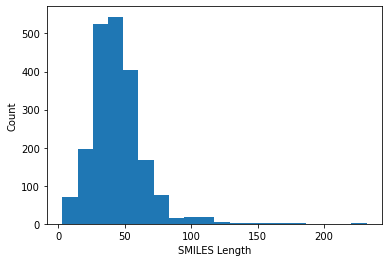

In [9]:
# plot histogram of smiles lengths
plt.hist(smiles_lengths_dict.values(), bins=20)
plt.xlabel('SMILES Length')
plt.ylabel('Count')
plt.show()


In [10]:
# print number of unique vocab
number_of_unique_vocab = len(vocab_count_dict)
print(number_of_unique_vocab)

# print all vocab counts
print(vocab_count_dict)

71
{'C': 26859, '(': 10491, ')': 10491, '=': 8034, 'c': 6937, 'O': 6142, '1': 4100, 'N': 3724, '2': 3362, '3': 2548, '4': 1434, '[C@H]': 1354, '[C@@H]': 893, 'Cl': 570, 'F': 509, 'n': 472, '5': 454, 'S': 405, '[C@@]': 350, '[C@]': 323, '\\': 203, '/': 184, '.': 163, '6': 124, '[S]': 103, '[N]': 77, 's': 72, '[O-]': 64, '7': 56, '#': 53, '[NH]': 50, '[N+]': 49, 'o': 48, 'Br': 45, '[Cl-]': 43, '[nH]': 40, '[H+]': 40, '8': 28, '[Na+]': 19, '9': 16, '[N@]': 14, '[P]': 11, '[N@@]': 8, '%10': 8, 'I': 6, '[Br-]': 6, '[Cl]': 5, '[H]': 4, '[N-]': 4, '%11': 4, '%12': 4, '%13': 4, '%14': 4, '[n+]': 2, '[NH+]': 2, '[Na]': 2, '[C-]': 2, '[NH2+]': 2, '[NH2]': 1, '[Ca++]': 1, '[S@]': 1, '[OH-]': 1, '[nH+]': 1, '[o+]': 1, '[NH3+]': 1, '[CH2-]': 1, '[CH-]': 1, 'B': 1, '[S+]': 1, '[O+]': 1, '[NH-]': 1}


In [11]:
print(vocab_2_index_dict)

print(index_2_vocab_dict)

{'#': 0, '%10': 1, '%11': 2, '%12': 3, '%13': 4, '%14': 5, '(': 6, ')': 7, '.': 8, '/': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, '=': 19, 'B': 20, 'Br': 21, 'C': 22, 'Cl': 23, 'F': 24, 'I': 25, 'N': 26, 'O': 27, 'S': 28, '[Br-]': 29, '[C-]': 30, '[C@@H]': 31, '[C@@]': 32, '[C@H]': 33, '[C@]': 34, '[CH-]': 35, '[CH2-]': 36, '[Ca++]': 37, '[Cl-]': 38, '[Cl]': 39, '[H+]': 40, '[H]': 41, '[N+]': 42, '[N-]': 43, '[N@@]': 44, '[N@]': 45, '[NH+]': 46, '[NH-]': 47, '[NH2+]': 48, '[NH2]': 49, '[NH3+]': 50, '[NH]': 51, '[N]': 52, '[Na+]': 53, '[Na]': 54, '[O+]': 55, '[O-]': 56, '[OH-]': 57, '[P]': 58, '[S+]': 59, '[S@]': 60, '[S]': 61, '[n+]': 62, '[nH+]': 63, '[nH]': 64, '[o+]': 65, '\\': 66, 'c': 67, 'n': 68, 'o': 69, 's': 70}
{0: '#', 1: '%10', 2: '%11', 3: '%12', 4: '%13', 5: '%14', 6: '(', 7: ')', 8: '.', 9: '/', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: '=', 20: 'B', 21: 'Br', 22: 'C', 23: 'Cl', 24: 'F', 

In [12]:
smiles_2_index_dict = {}

for smiles_str, matches in smiles_2_vocab_dict.items():
    smiles_2_index_dict[smiles_str] = [vocab_2_index_dict[match] for match in matches]

# print first smiles string with its vocab and index
print(smiles[0])
print(smiles_2_vocab_dict[smiles[0]])
print(smiles_2_index_dict[smiles[0]])
    

[Cl].CC(C)NCC(O)COc1cccc2ccccc12
['[Cl]', '.', 'C', 'C', '(', 'C', ')', 'N', 'C', 'C', '(', 'O', ')', 'C', 'O', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']
[39, 8, 22, 22, 6, 22, 7, 26, 22, 22, 6, 27, 7, 22, 27, 67, 10, 67, 67, 67, 67, 11, 67, 67, 67, 67, 67, 10, 11]


In [13]:
len(smiles_2_index_dict[smiles_str])

42

In [14]:
smiles_onehot_dict = {}

for i, smiles_str in enumerate(smiles_2_index_dict.keys()):
    smiles_onehot_dict[smiles_str] = np.zeros((max_smiles_len, number_of_unique_vocab))
    smiles_onehot_dict[smiles_str][np.arange(len(smiles_2_index_dict[smiles_str])), smiles_2_index_dict[smiles_str]] = 1

print(smiles_onehot_dict[smiles[0]].shape)

(232, 71)


In [15]:
# for check we convert one hot to smiles
reconstructed_smiles = []
for smiles_str in smiles_2_index_dict.keys():
    onehot = smiles_onehot_dict[smiles_str]
    indices = np.where(onehot == 1)
    smiles_str = "".join([index_2_vocab_dict[index] for index in indices[1]])
    reconstructed_smiles.append(smiles_str)


print(smiles[0])
print(reconstructed_smiles[0])

# compare smiles and reconstructed_smiles
for smiles_str, reconstructed_smiles_str in zip(smiles, reconstructed_smiles):
    if smiles_str != reconstructed_smiles_str:
        print("Error!")
        print(smiles_str)
        print(reconstructed_smiles_str)
        break

[Cl].CC(C)NCC(O)COc1cccc2ccccc12
[Cl].CC(C)NCC(O)COc1cccc2ccccc12


# dataset

In [16]:
p_np_tensor_list = []
smiles_onehot_tensor_list = []

for smiles_str in smiles:
    # Assuming smiles_pnp_dict and smiles_onehot_dict contain numerical data
    p_np_tensor = torch.tensor(smiles_pnp_dict[smiles_str], dtype=torch.float32)
    smiles_onehot_tensor = torch.tensor(smiles_onehot_dict[smiles_str], dtype=torch.float32)

    p_np_tensor_list.append(p_np_tensor)
    smiles_onehot_tensor_list.append(smiles_onehot_tensor)
    
    

In [17]:
# we want train a pytorch fully connected model for classification
# labels are in p_np
# inputs are in smiles_one_hot

# create a dataset class
class BBBPDataset(Dataset):
    def __init__(self, smiles_onehot_tensor_list, p_np_tensor_list):
        self.datas = smiles_onehot_tensor_list
        self.labels = p_np_tensor_list
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        data = self.datas[idx]
        label = self.labels[idx]

        return data, label
    
dataset = BBBPDataset(smiles_onehot_tensor_list, p_np_tensor_list)

# FC claassification

In [18]:
# create a fully connected model
# the input of model are [input_size, hidden_leyers, output_size]
# hidden_layers is a list of hidden layers size
# we use nn.Sequential
# output size is 1 because we have binary classification


class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size = 1):
        super(FullyConnected, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        
        self.layers = []
        
        # first layer
        self.layers.append(nn.Linear(self.input_size, self.hidden_layers[0]))
        self.layers.append(nn.ReLU())
        
        # hidden layers
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
            self.layers.append(nn.ReLU())
        
        # output layer
        self.layers.append(nn.Linear(self.hidden_layers[-1], self.output_size))
        self.layers.append(nn.Sigmoid())
        
        self.fc = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.fc(x)
    
# we flatten the input
# create a model
# print input size
print("input_size = ", number_of_unique_vocab * max_smiles_len)

fc_model = FullyConnected(number_of_unique_vocab * max_smiles_len, [2000, 200, 10], 1)




input_size =  16472


In [19]:
# create dataloader
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# create loss function
loss_fn = nn.BCELoss()

# create optimizer
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

# move model to device
fc_model = fc_model.to(device)

In [20]:
# train model
epochs = 4
train_losses = []
test_losses = []
train_accuracies = []
train_precisions = []
test_accuracies = []
test_precisions = []

for epoch_i in range(epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    train_precision = 0
    test_accuracy = 0
    test_precision = 0
    
    print("epoch_i = ", epoch_i)
    # train
    fc_model.train()
    for X, y in train_dataloader:
        X = X.view(X.shape[0], -1)
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred = fc_model(X.float())
        
        loss = loss_fn(y_pred, y.float().unsqueeze(1))
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        y_pred = y_pred.detach().cpu().numpy()
        y_pred = np.where(y_pred > 0.5, 1, 0)
        y = y.cpu().numpy()
        
        train_accuracy += accuracy_score(y, y_pred)
        train_precision += precision_score(y, y_pred, average='binary', zero_division=1)
        
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)
    train_precision /= len(train_dataloader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)

    # print train loss, train accuracy, train precision in 1 line with 2 decimal points
    print("train_loss = {:.2f}, train_accuracy = {:.2f}, train_precision = {:.2f}".format(train_loss, train_accuracy, train_precision))
    
    # test
    fc_model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.view(X.shape[0], -1)
            X = X.to(device)
            y = y.to(device)
            
            y_pred = fc_model(X.float())
            
            loss = loss_fn(y_pred, y.float().unsqueeze(1))
            
            test_loss += loss.item()
            
            y_pred = y_pred.detach().cpu().numpy()
            y_pred = np.where(y_pred > 0.5, 1, 0)
            y = y.cpu().numpy()
            
            test_accuracy += accuracy_score(y, y_pred)
            test_precision += precision_score(y, y_pred, average='binary', zero_division=1)
            
    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)
    test_precision /= len(test_dataloader)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)

    # print test loss, test accuracy, test precision in 1 line with 2 decimal points
    print("test_loss = {:.2f}, test_accuracy = {:.2f}, test_precision = {:.2f}".format(test_loss, test_accuracy, test_precision))


epoch_i =  0
train_loss = 0.39, train_accuracy = 0.80, train_precision = 0.86
test_loss = 0.36, test_accuracy = 0.80, test_precision = 0.96
epoch_i =  1
train_loss = 0.22, train_accuracy = 0.91, train_precision = 0.95
test_loss = 0.31, test_accuracy = 0.85, test_precision = 0.91
epoch_i =  2
train_loss = 0.12, train_accuracy = 0.95, train_precision = 0.97
test_loss = 0.39, test_accuracy = 0.86, test_precision = 0.89
epoch_i =  3
train_loss = 0.06, train_accuracy = 0.98, train_precision = 0.99
test_loss = 0.52, test_accuracy = 0.88, test_precision = 0.91


In [21]:
def plot_stats(train_losses, test_losses, train_accuracies, test_accuracies, train_precisions, test_precisions):
    # plot train and test losses
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot train and test accuracies
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(test_accuracies, label='test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

    # plot train and test precisions
    plt.plot(train_precisions, label='train precision')
    plt.plot(test_precisions, label='test precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()


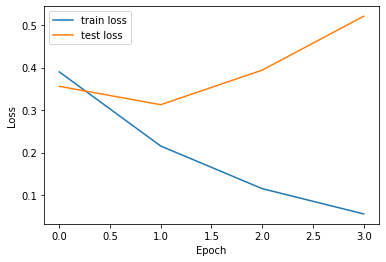

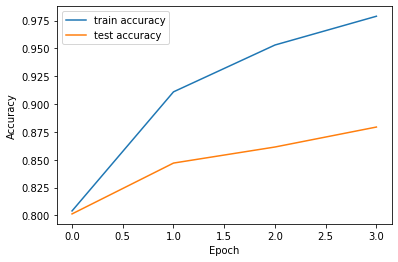

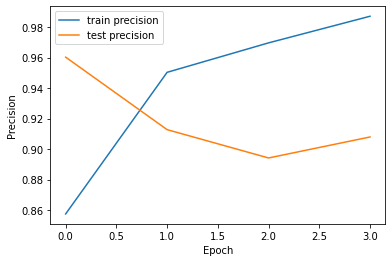

In [22]:
plot_stats(train_losses, test_losses, train_accuracies, test_accuracies, train_precisions, test_precisions)

In [23]:
final_FC_accuracy = test_accuracies[-1]
final_FC_precision = test_precisions[-1]

print("final fully connected accuracy = {:.2f}".format(final_FC_accuracy))
print("final fully connected precision = {:.2f}".format(final_FC_precision))

final fully connected accuracy = 0.88
final fully connected precision = 0.91


# LSTM

In [24]:
# we create a LSTM model
# the input of model are [input_size, lstm_output_size, fc_hidden_layers, output_size]

class My_lstm(nn.Module):
    def __init__(self, input_size, lstm_output_size, fc_hidden_layers, output_size = 1, bidirectional=False):
        super(My_lstm, self).__init__()
        self.input_size = input_size
        self.lstm_output_size = lstm_output_size
        self.fc_hidden_layers = fc_hidden_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(self.input_size, self.lstm_output_size, batch_first=True, bidirectional=bidirectional)
        
        self.layers = []
        
        # first layer
        self.layers.append(nn.Linear(self.lstm_output_size, self.fc_hidden_layers[0]))
        self.layers.append(nn.ReLU())
        
        # hidden layers
        for i in range(len(self.fc_hidden_layers)-1):
            self.layers.append(nn.Linear(self.fc_hidden_layers[i], self.fc_hidden_layers[i+1]))
            self.layers.append(nn.ReLU())
        
        # output layer
        self.layers.append(nn.Linear(self.fc_hidden_layers[-1], self.output_size))
        self.layers.append(nn.Sigmoid())
        
        self.fc = nn.Sequential(*self.layers)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)
    



In [25]:
def train_lstm(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=4, 
               add_data_noise=False, data_noise_std=0.01):
    train_losses, train_accuracies, train_precisions = [], [], []
    test_losses, test_accuracies, test_precisions = [], [], []

    model = model.to(device)

    for epoch_i in range(epochs):
        train_loss = 0
        train_accuracy = 0
        train_precision = 0

        model.train()
        for X, y in train_dataloader:



            X = X.to(device)
            y = y.to(device)


            if add_data_noise:
                X += torch.randn_like(X) * data_noise_std
           

            optimizer.zero_grad()

            y_pred = model(X.float())

            loss = loss_fn(y_pred, y.float().unsqueeze(1))

            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            y_pred = y_pred.detach().cpu().numpy()
            y_pred = np.where(y_pred > 0.5, 1, 0)
            y = y.cpu().numpy()

            train_accuracy += accuracy_score(y, y_pred)
            train_precision += precision_score(y, y_pred, average='binary', zero_division=1)

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_precision /= len(train_dataloader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        print("Epoch {}: train_loss = {:.2f}, train_accuracy = {:.2f}, train_precision = {:.2f}".format(epoch_i, train_loss, train_accuracy, train_precision))

        model.eval()
        with torch.no_grad():
            test_loss = 0
            test_accuracy = 0
            test_precision = 0

            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X.float())

                loss = loss_fn(y_pred, y.float().unsqueeze(1))

                test_loss += loss.item()

                y_pred = y_pred.detach().cpu().numpy()
                y_pred = np.where(y_pred > 0.5, 1, 0)
                y = y.cpu().numpy()

                test_accuracy += accuracy_score(y, y_pred)
                test_precision += precision_score(y, y_pred, average='binary', zero_division=1)

            test_loss /= len(test_dataloader)
            test_accuracy /= len(test_dataloader)
            test_precision /= len(test_dataloader)

            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            test_precisions.append(test_precision)

            print("Test: test_loss = {:.2f}, test_accuracy = {:.2f}, test_precision = {:.2f}".format(test_loss, test_accuracy, test_precision))
            print("-" * 30)

    
    return train_losses, train_accuracies, train_precisions, test_losses, test_accuracies, test_precisions


In [26]:
def k_fold_cross_validation(model, dataset, loss_fn, optimizer, device, k=5, batch_size=32, epochs=4, 
               add_data_noise=False, data_noise_std=0.01):
    kf = KFold(n_splits=k, shuffle=True)

    avg_train_losses, avg_train_accuracies, avg_train_precisions = [], [], []
    avg_test_losses, avg_test_accuracies, avg_test_precisions = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f"\nFold {fold + 1}/{k}")

        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        stat = train_lstm(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=epochs, 
                          add_data_noise=add_data_noise, data_noise_std=data_noise_std)
        train_losses, train_accuracies, train_precisions, test_losses, test_accuracies, test_precisions = stat

        avg_train_losses.append(train_losses)
        avg_train_accuracies.append(train_accuracies)
        avg_train_precisions.append(train_precisions)

        avg_test_losses.append(test_losses)
        avg_test_accuracies.append(test_accuracies)
        avg_test_precisions.append(test_precisions)


        print("=" * 50)

    avg_train_losses = np.array(avg_train_losses).mean(axis=0)
    avg_train_accuracies = np.array(avg_train_accuracies).mean(axis=0)
    avg_train_precisions = np.array(avg_train_precisions).mean(axis=0)

    avg_test_losses = np.array(avg_test_losses).mean(axis=0)
    avg_test_accuracies = np.array(avg_test_accuracies).mean(axis=0)
    avg_test_precisions = np.array(avg_test_precisions).mean(axis=0)

    return avg_train_losses, avg_train_accuracies, avg_train_precisions, avg_test_losses, avg_test_accuracies, avg_test_precisions

In [27]:
lstm_model = My_lstm(number_of_unique_vocab, 100, [200, 20, 5], 1)

# create loss function
loss_fn = nn.BCELoss()

# create optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# move model to device
lstm_model = lstm_model.to(device)


stat = k_fold_cross_validation(lstm_model, dataset, loss_fn, optimizer, device, k=5, epochs=10,
                               add_data_noise=True, data_noise_std=0.1)




Fold 1/5
Epoch 0: train_loss = 0.57, train_accuracy = 0.77, train_precision = 0.77
Test: test_loss = 0.56, test_accuracy = 0.76, test_precision = 0.76
------------------------------
Epoch 1: train_loss = 0.55, train_accuracy = 0.77, train_precision = 0.77
Test: test_loss = 0.55, test_accuracy = 0.76, test_precision = 0.76
------------------------------
Epoch 2: train_loss = 0.54, train_accuracy = 0.77, train_precision = 0.77
Test: test_loss = 0.55, test_accuracy = 0.76, test_precision = 0.76
------------------------------
Epoch 3: train_loss = 0.54, train_accuracy = 0.77, train_precision = 0.77
Test: test_loss = 0.55, test_accuracy = 0.76, test_precision = 0.76
------------------------------
Epoch 4: train_loss = 0.54, train_accuracy = 0.77, train_precision = 0.77
Test: test_loss = 0.55, test_accuracy = 0.76, test_precision = 0.76
------------------------------
Epoch 5: train_loss = 0.54, train_accuracy = 0.77, train_precision = 0.77
Test: test_loss = 0.55, test_accuracy = 0.76, test_

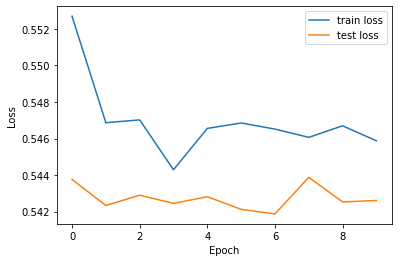

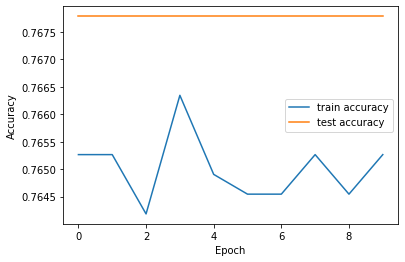

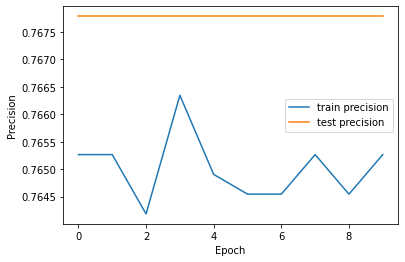

In [28]:
avg_train_losses, avg_train_accuracies, avg_train_precisions, avg_test_losses, avg_test_accuracies, avg_test_precisions = stat
plot_stats(avg_train_losses, avg_test_losses, avg_train_accuracies, avg_test_accuracies, avg_train_precisions, avg_test_precisions)

In [29]:
final_lstm_accuracy = avg_test_accuracies[-1]
final_lstm_precision = avg_test_precisions[-1]

print("final LSTM accuracy = {:.2f}".format(final_lstm_accuracy))
print("final LSTM precision = {:.2f}".format(final_lstm_precision))

final LSTM accuracy = 0.77
final LSTM precision = 0.77


# Bi LSTM

<div dir="rtl">
<font face="B Nazanin" size="5">
سایز خروجی LSTM
را باید دو برابر ذکر کنیم تا شبکه عوض نشود
</font>
</div>

In [30]:
lstm_model = My_lstm(number_of_unique_vocab, 200, [200, 20, 5], 1, bidirectional=False)

# create loss function
loss_fn = nn.BCELoss()

# create optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# move model to device
lstm_model = lstm_model.to(device)


stat = k_fold_cross_validation(lstm_model, dataset, loss_fn, optimizer, device, k=5, epochs=10,
                               add_data_noise=True, data_noise_std=0.1)




Fold 1/5
Epoch 0: train_loss = 0.57, train_accuracy = 0.76, train_precision = 0.76
Test: test_loss = 0.53, test_accuracy = 0.78, test_precision = 0.78
------------------------------
Epoch 1: train_loss = 0.55, train_accuracy = 0.76, train_precision = 0.76
Test: test_loss = 0.53, test_accuracy = 0.78, test_precision = 0.78
------------------------------
Epoch 2: train_loss = 0.55, train_accuracy = 0.76, train_precision = 0.76
Test: test_loss = 0.53, test_accuracy = 0.78, test_precision = 0.78
------------------------------
Epoch 3: train_loss = 0.55, train_accuracy = 0.76, train_precision = 0.76
Test: test_loss = 0.53, test_accuracy = 0.78, test_precision = 0.78
------------------------------
Epoch 4: train_loss = 0.55, train_accuracy = 0.76, train_precision = 0.76
Test: test_loss = 0.54, test_accuracy = 0.78, test_precision = 0.78
------------------------------
Epoch 5: train_loss = 0.55, train_accuracy = 0.76, train_precision = 0.76
Test: test_loss = 0.53, test_accuracy = 0.78, test_

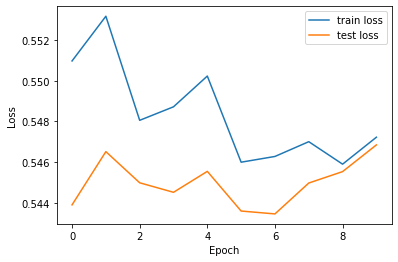

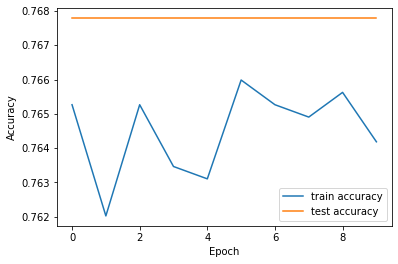

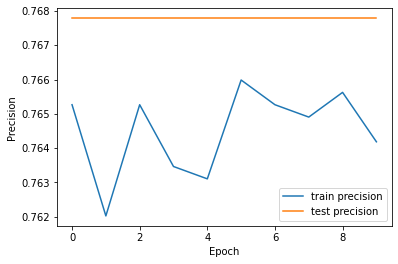

In [31]:
avg_train_losses, avg_train_accuracies, avg_train_precisions, avg_test_losses, avg_test_accuracies, avg_test_precisions = stat
plot_stats(avg_train_losses, avg_test_losses, avg_train_accuracies, avg_test_accuracies, avg_train_precisions, avg_test_precisions)

In [32]:
final_bi_lstm_accuracy = avg_test_accuracies[-1]
final_bi_lstm_precision = avg_test_precisions[-1]

print("final Bi LSTM accuracy = {:.2f}".format(final_bi_lstm_accuracy))
print("final Bi LSTM precision = {:.2f}".format(final_bi_lstm_precision))

final Bi LSTM accuracy = 0.77
final Bi LSTM precision = 0.77
